## Benchmark: ARIMA, RNN & LSTM

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

import sys
sys.path.append('../Transformer')
from utils import data_read_dict, data_read_concat, data_merge


Functions

In [3]:
def actual_pred_plot(preds, y_test):
    '''
    Plot the actual vs. prediction
    '''
    actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
    actual_pred['prediction'] = preds[:,0]
    actual_pred['Adj. Close'] = y_test[:,0]  #.loc['2019':,'Adj Close'][0:len(preds)]

    from tensorflow.keras.metrics import MeanSquaredError
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Adj. Close']),np.array(actual_pred['prediction']))
    return (m.result().numpy(), actual_pred.plot() )

### Data

In [4]:
import pandas as pd


FXSpot_path = '../data/10min Dataset Spot.csv'

df = pd.read_csv(FXSpot_path, delimiter=';')

df.replace(to_replace=0, method='ffill', inplace=True) # Replace 0 to avoid dividing by 0 later on
df['Dates'] = pd.to_datetime(df['Dates'], format='%d.%m.%y %H:%M')
df.sort_values('Dates', inplace=True)
df.index = df['Dates']
'''Calculate percentage change for FX Spot Rates'''
df = df.set_index('Dates')
df = df.pct_change()
'''==============='''
FX_Fundamentals_path = '../data/10min Dataset Rest.csv'

df2 = pd.read_csv(FX_Fundamentals_path, delimiter=';')

df2.replace(to_replace=0, method='ffill', inplace=True) # Replace 0 to avoid dividing by 0 later on
df2.drop('UXA1 Comdty Trade Open', axis=1, inplace=True)
df2['Dates'] = pd.to_datetime(df2['Dates'], format='%d.%m.%y %H:%M')
df2.sort_values('Dates', inplace=True)
df2.sort_values('Dates')
df2.index = df2['Dates']
df_metrics = data_merge(data_read_dict('../data/bbg/'))
df_metrics.shape
df_metrics

df3 = pd.merge(df, df2, left_index=True, right_index=True)
df3['Dates'] = pd.to_datetime(df3['Dates'], format='%d.%m.%y %H:%M')
df3.index = df3['Dates']

df_merged = pd.merge(df3, df_metrics, left_index=True, right_index=True, how='outer')
df_merged = df_merged.loc[df_merged.index <= max(df3.Dates),:]
df = df_merged[:]
df = df.set_index('Dates')

df = df.asfreq('600S')
df.ffill(inplace=True)
df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values"
set(np.diff(df.index.values))

{numpy.timedelta64(600000000000,'ns')}

<AxesSubplot:xlabel='Dates'>

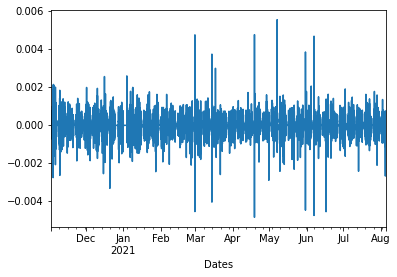

In [5]:
df['EURUSD BGNE Curncy Bid Close'].plot()

## Create training and test data for RNN/LSTM

In [6]:
def ts_train_test_normalize(df,time_steps,for_periods):
    '''
    input: 
      data: dataframe with dates and price data
    output:
      X_train, y_train: data from 2020/11/2-2020/12/31
      X_test:  data from 2021 -
      sc:      insantiated MinMaxScaler object fit to the training data
    '''    # create training and test set
    target_column = 3
    times = sorted(df.index.values)
    last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
    last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

    ts_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
    ts_test = df[(df.index >= last_20pct) & (df.index < last_10pct)]

    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    '''Normalize price columns'''
    df = (df - df.mean()) / (df.max() - df.min())
    df.columns[np.isnan(df).any(axis=0)]
    
    sc = MinMaxScaler().fit(ts_train)
    sc_target = MinMaxScaler().fit(ts_train.iloc[:, target_column:target_column+1])
    ts_train_scaled = sc.transform(ts_train)
    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train_scaled[i-time_steps:i])
        y_train.append(ts_train_scaled[i:i+for_periods,target_column])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
#     X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    ts_test_scaled = sc.transform(ts_test)
    # Preparing X_test
    X_test = []
    y_test = []
    for i in range(time_steps,ts_test_len-for_periods):
        X_test.append(ts_test_scaled[i-time_steps:i])
        y_test.append(ts_test_scaled[i:i+for_periods,target_column])
    
    X_test, y_test = np.array(X_test), np.array(y_test)
#     X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

    return X_train, y_train , X_test, y_test, sc, sc_target

In [27]:
X_train, y_train, X_test, y_test, sc, sc_target = ts_train_test_normalize(df,5,1)

Epoch 1/10
212/212 [==============================] - 12s 34ms/step - loss: 0.1904
Epoch 2/10
212/212 [==============================] - 7s 34ms/step - loss: 0.0591
Epoch 3/10
212/212 [==============================] - 7s 33ms/step - loss: 0.0447
Epoch 4/10
212/212 [==============================] - 7s 33ms/step - loss: 0.0343
Epoch 5/10
212/212 [==============================] - 6s 30ms/step - loss: 0.0315
Epoch 6/10
212/212 [==============================] - 7s 32ms/step - loss: 0.0284
Epoch 7/10
212/212 [==============================] - 8s 36ms/step - loss: 0.0265
Epoch 8/10
212/212 [==============================] - 8s 37ms/step - loss: 0.0271
Epoch 9/10
212/212 [==============================] - 8s 38ms/step - loss: 0.0255
Epoch 10/10
212/212 [==============================] - 8s 36ms/step - loss: 0.0239


(0.0011100968, <AxesSubplot:>)

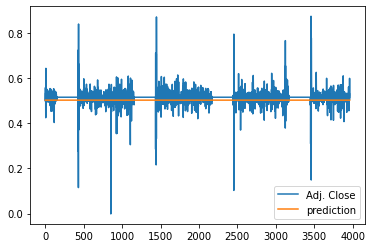

In [37]:
from tensorflow.keras.layers import LayerNormalization
def simple_rnn_model(X_train, y_train, X_test, sc_target):
    '''
    create single layer rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, SimpleRNN

    dr = 0
    my_rnn_model = Sequential()
    my_rnn_model.add(SimpleRNN(128, return_sequences=True, activation='ReLU', dropout=dr))
    my_rnn_model.add(LayerNormalization(epsilon=1e-6))
    my_rnn_model.add(SimpleRNN(128, return_sequences=True, activation='ReLU', dropout=dr))
    my_rnn_model.add(LayerNormalization(epsilon=1e-6))
    my_rnn_model.add(SimpleRNN(128, return_sequences=True, activation='ReLU', dropout=dr))
    my_rnn_model.add(LayerNormalization(epsilon=1e-6))
    my_rnn_model.add(SimpleRNN(128, return_sequences=True, activation='ReLU', dropout=dr))
    my_rnn_model.add(LayerNormalization(epsilon=1e-6))
    my_rnn_model.add(SimpleRNN(128, return_sequences=True, activation='ReLU', dropout=dr))
    my_rnn_model.add(LayerNormalization(epsilon=1e-6))
    my_rnn_model.add(SimpleRNN(128, return_sequences=True, activation='ReLU', dropout=dr))
    my_rnn_model.add(LayerNormalization(epsilon=1e-6))
    my_rnn_model.add(SimpleRNN(64, activation='ReLU'))
    my_rnn_model.add(Dense(32, activation='ReLU'))
    my_rnn_model.add(Dense(y_train.shape[1])) # The time step of the output

#     my_rnn_model.compile(optimizer='rmsprop', loss='mean_squared_error')
    my_rnn_model.compile(optimizer='rmsprop', loss='mean_absolute_error')

    # fit the RNN model
    history = my_rnn_model.fit(X_train, y_train, epochs=10, batch_size=150, verbose=1)

    # Finalizing predictions
    rnn_predictions = my_rnn_model.predict(X_test)
#     rnn_predictions = sc_target.inverse_transform(rnn_predictions)
    return my_rnn_model, rnn_predictions, history
my_rnn_model, rnn_predictions, history = simple_rnn_model(X_train, y_train, X_test, sc_target)
actual_pred_plot(rnn_predictions, y_test)

In [38]:
my_rnn_model.summary()
# actual_pred_plot(rnn_predictions, y_test)
y_test
print(rnn_predictions.shape, y_test.shape)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_42 (SimpleRNN)    (None, 5, 128)            179456    
_________________________________________________________________
layer_normalization_16 (Laye (None, 5, 128)            256       
_________________________________________________________________
simple_rnn_43 (SimpleRNN)    (None, 5, 128)            32896     
_________________________________________________________________
layer_normalization_17 (Laye (None, 5, 128)            256       
_________________________________________________________________
simple_rnn_44 (SimpleRNN)    (None, 5, 128)            32896     
_________________________________________________________________
layer_normalization_18 (Laye (None, 5, 128)            256       
_________________________________________________________________
simple_rnn_45 (SimpleRNN)    (None, 5, 128)          

(0.0009671505, <AxesSubplot:>)

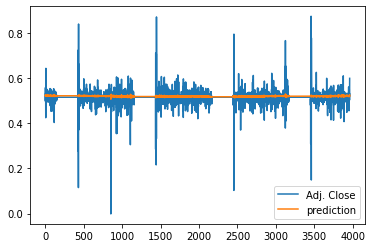

In [19]:
actual_pred_plot(my_rnn_model.predict(X_test), y_test)

## LSTM

In [ ]:
def LSTM_model(X_train, y_train, X_test, sc):
    # create a model
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, SimpleRNN, GRU, LSTM
    from tensorflow.keras.optimizers import SGD
    
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=X_train.shape[1:], activation='tanh'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=50, activation='tanh'))
    my_LSTM_model.add(Dense(units=2))

    # Compiling
    my_LSTM_model.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
    # Fitting to the training set
    my_LSTM_model.fit(X_train,y_train,epochs=5,batch_size=150, verbose=1)

    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction

my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test, sc_target)
actual_pred_plot(LSTM_prediction, y_test)

## LSTM Regularization
!!!Q: how is the 

In [ ]:
def LSTM_model_regularization(X_train, y_train, X_test, sc):
    # create a model
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, SimpleRNN, GRU, LSTM, Dropout
    from tensorflow.keras.optimizers import SGD
    
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=X_train.shape[1:], activation='tanh'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=50, activation='tanh'))
    my_LSTM_model.add(Dropout(0.2))
    my_LSTM_model.add(Dense(units=2))

    # Compiling
    my_LSTM_model.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
    # Fitting to the training set
    my_LSTM_model.fit(X_train,y_train,epochs=5,batch_size=150, verbose=1)

    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction

my_LSTM_model, LSTM_prediction = LSTM_model_regularization(X_train, y_train, X_test, sc_target)
LSTM_prediction[1:10]
actual_pred_plot(LSTM_prediction, y_test)